In [12]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import pickle
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import *
import umap
import os
from sknetwork.clustering import Louvain,get_modularity
ephys = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds.pkl")
all_vals = pd.read_pickle("D:/FN_analysed_feat_set/val_collection_all_exps_all_conds.pkl")

In [14]:
# all_vals[['exp_name','MI']]
ephys['MI']= all_vals['MI'] 


In [4]:
def plot_UMAP_clusters_single(data_inh, neighbours, distance, res_louvain, random_state,annotate=False,norm=True, c_list=None ,save=False):
    """plots UMAP for excitatory and inhibitory cells 

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """
    data_umap_scaler = StandardScaler()
    data_umap = data_umap_scaler.fit_transform(data_inh)
    if norm:
        data_umap = normalize(data_umap)
    
    neighbours = neighbours
    dist = distance
    reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)
    mapper = reducer.fit(data_umap)
    
    fig = plt.figure(figsize=[8,8])
    ax12d = fig.add_subplot(1,1,1)
    
    louvain = Louvain(resolution=res_louvain,random_state=random_state)
    adjacency = mapper.graph_
    labels_exc = louvain.fit_predict(adjacency)

    print(len(set(labels_exc)))
    clusterable_embedding2d = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_umap)



    df_2d_exc = {'UMAP1':clusterable_embedding2d[:, 0],
             'UMAP2':clusterable_embedding2d[:, 1],
             'class':labels_exc}

    ax12d.set_xticks([])
    ax12d.set_yticks([])

    sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
    if annotate:
        for i in range(len(clusterable_embedding2d)):

            plt.annotate(str(i),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))

        # sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',ax=ax12d)

        # ax12d.set_title('UMAP clusters for excitatory neurons 2D')
        ax12d.legend()
    if save:
        plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/exc_umap_cluster.png',dpi=200)
    
    plt.show()

    return labels_exc,mapper,reducer

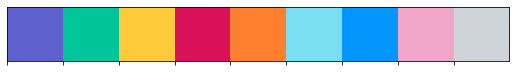

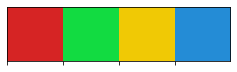

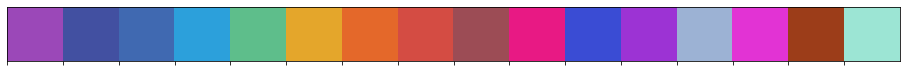

In [30]:
pal = ["#00202e","#003f5c","#2c4875","#8a508f","#bc5090","#ff6361","#ff8531","#ffa600","#ffd380"]
CUSTOM_PAL_SORT_3 = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da']
GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

# In RGB form
coherence_colors = [[0.609, 0.283, 0.724],
                    [0.259,	0.314, 0.635],
                    [0.251,	0.412, 0.698],
                    [0.176,	0.631, 0.859],
                    [0.369,	0.749, 0.549],
                    [0.898,	0.654, 0.169],
                    [0.898,	0.41 , 0.165],
                    [0.834,	0.3 , 0.265],
                    [0.612,	0.3 , 0.334],
                    [0.912,	0.1 , 0.52],
                    [0.23,	0.3 , 0.834],
                    [0.612,	0.2 , 0.834],
                    [0.612,	0.7 , 0.834],
                    [0.89,	0.2 , 0.834],
                    [0.612,	0.24 , 0.1],
                    [0.612,	0.9 , 0.834]]
sns.palplot(CUSTOM_PAL_SORT_3)
sns.palplot(GMM_PAL)
sns.palplot(coherence_colors)

322
306


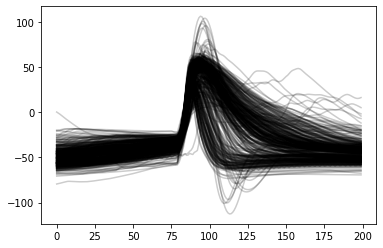

In [45]:
# data_wave_FN = pd.read_pickle('D:/CurrentClamp/all_waveforms_entire.pkl')
data_wave_FN = ephys

data_wave_FN.cond = [i.lower() for i in data_wave_FN.cond]
print(len(set(data_wave_FN.exp_name)))

# data_wave_FN.exp_name = [i[:-3] for i in data_wave_FN.exp_name]
data_wave_FN_acsf = data_wave_FN[data_wave_FN.cond=='acsf'] 
print(len(set(data_wave_FN_acsf.exp_name)))
fig = plt.Figure(figsize=[10,10])
plt.plot(np.vstack(data_wave_FN_acsf['waveform']).T,c='k',alpha=0.2)
plt.show()


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


10


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


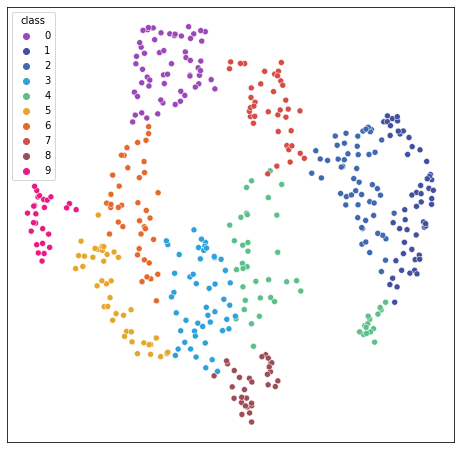

In [31]:
waves = normalize(np.vstack(data_wave_FN_acsf['waveform']))
lables_wave,mapper,reducer = plot_UMAP_clusters_single(waves,
                          20,
                          0.3,
                          random_state =42,
                          res_louvain = 1,
                          c_list =coherence_colors,
                          )

<ipython-input-32-eec5554734f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wave_FN_acsf['LV_ID'] = lables_wave


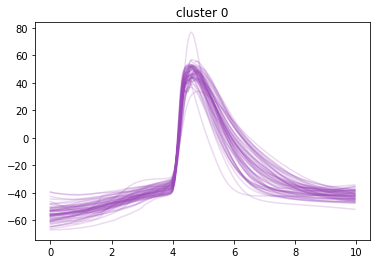

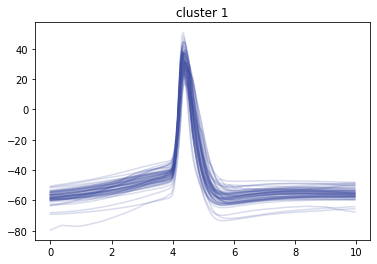

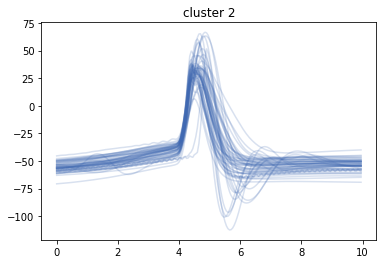

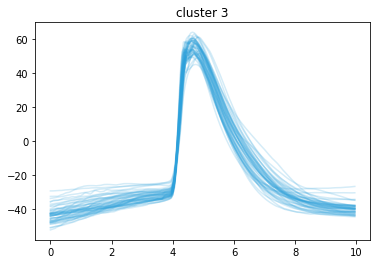

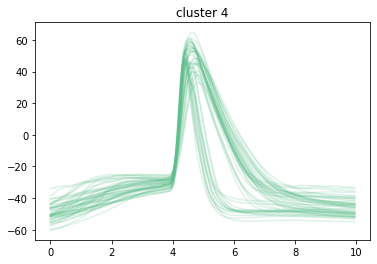

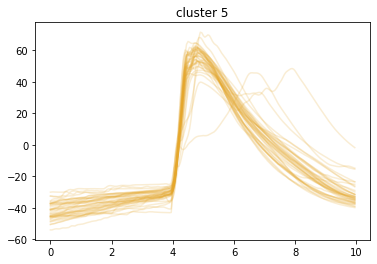

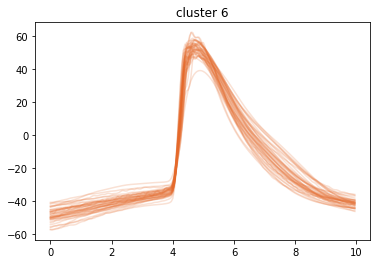

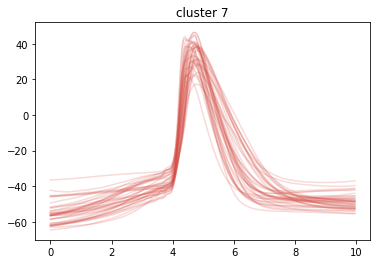

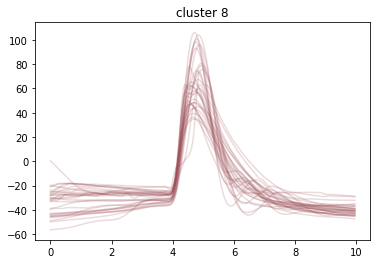

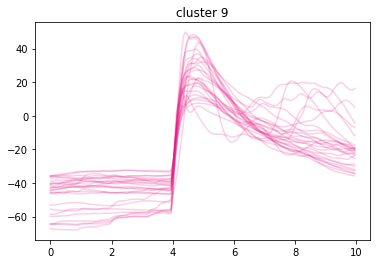

In [32]:
data_wave_FN_acsf['LV_ID'] = lables_wave
# ephys['wave_ID']
for i in range(len(set(lables_wave))):
    fig = plt.Figure(figsize=[5,5])
    to_plot = np.vstack(data_wave_FN_acsf[data_wave_FN_acsf.LV_ID==i]['waveform']).T
    plt.plot(np.arange(0,200/20,1/20),to_plot,c=coherence_colors[i],alpha=0.2)
    plt.title('cluster '+str(i))
    # plt.plot(np.mean(np.vstack(data_wave_FN[data_wave_FN.LV_ID==i]['waveforms']).T,axis=1),c=CUSTOM_PAL_SORT_3[i],alpha=0.2)
    plt.show()


In [42]:
len(data_wave_FN_acsf[data_wave_FN_acsf.trialnr==0])

306

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


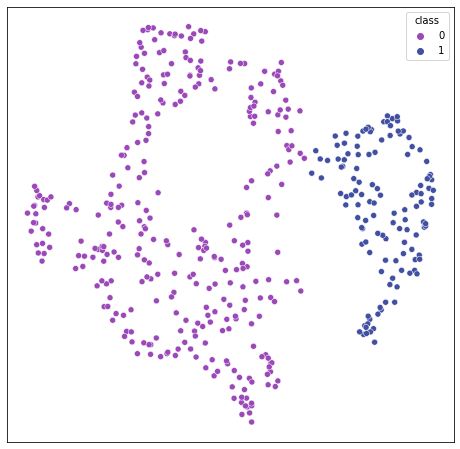

In [33]:
# new_wave = data_wave_FN_acsf[data_wave_FN_acsf.LV_ID!=9]

waves_new = normalize(np.vstack(data_wave_FN_acsf['waveform']))
lables_wave,mapper,reducer = plot_UMAP_clusters_single(waves_new,
                          20,
                          0.3,
                          random_state =42,
                          res_louvain = 0.1,
                          c_list =coherence_colors,
                          )




<ipython-input-23-218c086b0788>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_wave['LV_ID'] = lables_wave


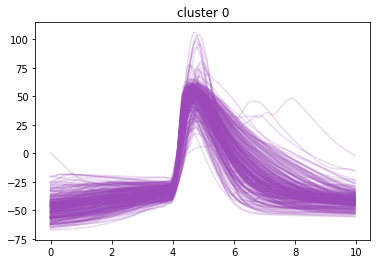

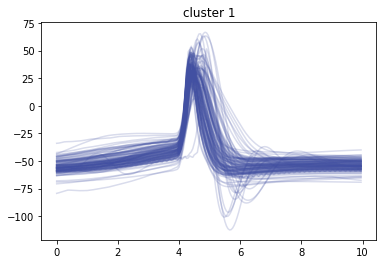

In [23]:
new_wave['LV_ID'] = lables_wave
for i in range(len(set(lables_wave))):
    fig = plt.Figure(figsize=[2,2])
    to_plot = np.vstack(new_wave[new_wave.LV_ID==i]['waveform']).T
    plt.plot(np.arange(0,200/20,1/20),to_plot,c=coherence_colors[i],alpha=0.2)
    plt.title('cluster '+str(i))
    # plt.plot(np.mean(np.vstack(data_wave_FN[data_wave_FN.LV_ID==i]['waveforms']).T,axis=1),c=CUSTOM_PAL_SORT_3[i],alpha=0.2)
    plt.show()

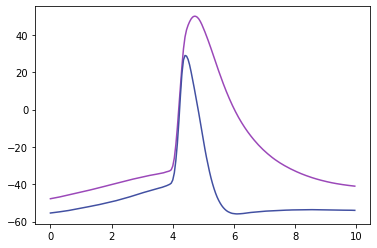

In [25]:
for i in range(len(set(lables_wave))):
    fig = plt.Figure(figsize=[2,2])
    to_plot = np.mean(np.vstack(new_wave[new_wave.LV_ID==i]['waveform']).T,axis=1)
    plt.plot(np.arange(0,200/20,1/20),to_plot,c=coherence_colors[i],alpha=1)
    # plt.title('cluster '+str(i))
    # plt.plot(np.mean(np.vstack(data_wave_FN[data_wave_FN.LV_ID==i]['waveforms']).T,axis=1),c=CUSTOM_PAL_SORT_3[i],alpha=0.2)
    # plt.show()

In [706]:
set(data_wave_FN.cond)
# conds = data_wave_FN.cond


{'acsf',
 'acsf_bic',
 'agoanta',
 'cirazoline',
 'd1',
 'd1ago',
 'd2',
 'dop',
 'dopa',
 'dopamine',
 'm1-ag',
 'm1-ago',
 'm1-ago+ant',
 'm1-ant',
 'm1-ant+ago',
 'sag'}

In [708]:
set(data_wave_FN.cond)
conds = data_wave_FN.cond

data_wave_FN = data_wave_FN.replace({'d1ago':'d1','m1-ag':'m1-ago','dop':'dopamine','dopa':'dopamine','m1-ago+ant':'m1-ant+ago'})


In [709]:
exps_exc = new_wave[new_wave.LV_ID==0].exp_name
exps_inh = new_wave[new_wave.LV_ID==1].exp_name

df_exc_FN = data_wave_FN[data_wave_FN.exp_name.isin(exps_exc)]
df_inh_FN = data_wave_FN[data_wave_FN.exp_name.isin(exps_inh)]


In [710]:

pd.DataFrame({'condition':np.unique(df_inh_FN.cond,return_counts=True)[0],'counts':np.unique(df_inh_FN.cond,return_counts=True)[1]})



,condition,counts
0,acsf,136
1,agoanta,19
2,cirazoline,22
3,d1,29
4,d2,13
5,dopamine,21
6,m1-ago,19
7,m1-ant,11
8,m1-ant+ago,6
9,sag,10


In [711]:
# np.unique(data_wave_FN_acsf.trialnr,return_counts=True)
df_temp_exps  = data_wave_FN_acsf[data_wave_FN_acsf.trialnr==2].exp_name
df_temp = data_wave_FN_acsf[data_wave_FN_acsf.exp_name.isin(df_temp_exps)]
df_temp =df_temp[df_temp.trialnr.isin([0,1])] 

In [734]:
from statannotations.Annotator import Annotator
def plot_significance(df, drug,var,path_try,paired=True,debug=True,save=False):
    fig = plt.Figure()
    if paired:
        exps_drug = df[df.cond.isin([drug])].exp_name
        df_drug = df[df.exp_name.isin(exps_drug)]
        df_drug = df_drug[df_drug.cond.isin(['acsf',drug])]
        df_acsf = df_drug[df_drug.cond=='acsf'].drop_duplicates('exp_name')
        # df_acsf_exps = df_acsf.exp_name[~df_acsf.isna()[var]] 
        df_drug = df_drug[df_drug.cond!='acsf'].drop_duplicates('exp_name')
        # df_drug = df_drug[df_drug.exp_name.isin(df_acsf_exps)]
    else:     
        df_drug = df[df.cond==drug]
        df_acsf = df[df.cond=='acsf']        
    df_drug = pd.concat([df_acsf,df_drug]) 
    df_drug.cond = pd.Categorical(df_drug['cond'])
    df_drug[var] = np.array(df_drug[var],dtype=np.float32)
    order = ['acsf',drug]
    df_drug = df_drug[df_drug.exp_name!='payam_101019_E5']
    if debug:
        return df_drug
    else:
        if paired:
            ax = sns.violinplot(data=df_drug,x='cond',y=var,dtype=np.float32)
            annot = Annotator(ax, [("acsf", drug)], data=df_drug, x='cond', y=var, order=order)
            annot.configure(test='t-test_paired', text_format='star', loc='outside', verbose=2)
            annot.apply_test()
            ax, test_results = annot.annotate()
        else:
            ax = sns.violinplot(data=df_drug,x='cond',y=var,dtype=np.float32)
            annot = Annotator(ax, [("acsf", drug)], data=df_drug, x='cond', y=var, order=order)
            annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
            annot.apply_test()
            ax, test_results = annot.annotate()

        if save:
            f_name = var+'_'+drug+'.png'
            if os.path.exists(path_try):
                plt.savefig(path_try+'/'+f_name,dpi=200,bbox_inches = "tight")
            else:
                os.mkdir(path_try)
                plt.savefig(path_try+'/'+f_name,dpi=200,bbox_inches = "tight")
            plt.close()
        else:
            plt.show()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test paired samples, P_val:9.767e-01 t=-2.960e-02


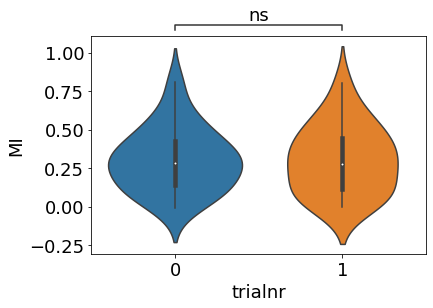

In [715]:
var='MI'
df_temp[var] = np.array(df_temp[var],dtype=np.float32)

order = [0,1]
ax = sns.violinplot(data=df_temp,x='trialnr',y=var,dtype=np.float32)
annot = Annotator(ax, [(0,1)], data=df_temp, x='trialnr', y=var, order=order)
annot.configure(test='t-test_paired', text_format='star', loc='outside', verbose=2)
annot.apply_test()
ax, test_results = annot.annotate()

In [416]:
all_drug_FN = set(df_exc_FN.cond)
df_exc_FN.columns


Index(['waveform', 'current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',
       'tau', 'exp_name', 'cond', 'trialnr'],
      dtype='object')

In [736]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
df_exc_FN = df_exc_FN.dropna() 
for drug in all_drug_FN:
    if drug !='acsf':
        for i in ['ap_count','fr','mean_isi','mean_thr','mean_width','mean_amplitude','MI']:
            path_temp = 'D:/figs_significance_all_conditions_FN/Exc_all_acsf_vs_drug/'+drug+'/'
            plot_significance(df_exc_FN,drug,i,path_try=path_temp,paired=False,debug=False,save=True) 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. m1-ant+ago: Mann-Whitney-Wilcoxon test two-sided, P_val:7.649e-01 U_stat=9.670e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. m1-ant+ago: Mann-Whitney-Wilcoxon test two-sided, P_val:7.517e-01 U_stat=1.109e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. m1-ant+ago: Mann-Whitney-Wilcoxon test two-sided, P_val:8.964e-01 U_stat=1.005e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



In [737]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
df_inh_FN = df_inh_FN.dropna() 
for drug in all_drug_FN:
    if drug !='acsf':
        for i in ['ap_count','fr','mean_isi','mean_thr','mean_width','mean_amplitude','MI']:
            path_temp = 'D:/figs_significance_all_conditions_FN/Inh_all_acsf_vs_drug/'+drug+'/'
            plot_significance(df_inh_FN,drug,i,path_try=path_temp,paired=False,debug=False,save=True) 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. m1-ant+ago: Mann-Whitney-Wilcoxon test two-sided, P_val:1.374e-01 U_stat=2.610e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. m1-ant+ago: Mann-Whitney-Wilcoxon test two-sided, P_val:1.489e-01 U_stat=2.640e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. m1-ant+ago: Mann-Whitney-Wilcoxon test two-sided, P_val:1.460e-01 U_stat=5.530e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



CC analysis


In [744]:
from statannotations.Annotator import Annotator
def plot_significance_CC(df, drug,var,path_try,paired=True,debug=True,save=False):
    fig = plt.Figure()
    if paired:
        df_drug = df[df.cond==drug]
        df_acsf = df_drug[df_drug.drug==False].drop_duplicates('exp_name')
        num_acsf = len(df_acsf) 
        # df_acsf_exps = df_acsf.exp_name[~df_acsf.isna()[var]] 
        df_drug = df_drug[df_drug.drug==True].drop_duplicates('exp_name')
        num_drug = len(df_drug)
        # df_drug = df_drug[df_drug.exp_name.isin(df_acsf_exps)]
    else:
        df_drug = df[df.cond==drug]
        df_acsf = df[df.drug==False]
        num_acsf = len(df_acsf) 
        num_drug = len(df_drug) 

    df_drug = pd.concat([df_acsf,df_drug]) 
    df_drug['for_plot'] = np.concatenate([np.repeat('acsf',num_acsf),np.repeat(drug,num_drug)])
    df_drug.cond = pd.Categorical(df_drug['cond'])
    df_drug[var] = np.array(df_drug[var],dtype=np.float32)
    order = ['acsf',drug]
    df_drug = df_drug[df_drug.exp_name!='payam_101019_E5']
    if debug:
        return df_drug
    else:
        if paired:
            ax = sns.violinplot(data=df_drug,x='for_plot',y=var,dtype=np.float32)
            annot = Annotator(ax, [("acsf", drug)], data=df_drug, x='for_plot', y=var, order=order)
            annot.configure(test='t-test_paired', text_format='star', loc='outside', verbose=2)
            annot.apply_test()
            ax, test_results = annot.annotate()
        else:
            ax = sns.violinplot(data=df_drug,x='for_plot',y=var,dtype=np.float32)
            annot = Annotator(ax, [("acsf", drug)], data=df_drug, x='for_plot', y=var, order=order)
            annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
            annot.apply_test()
            ax, test_results = annot.annotate()

        if save:
            f_name = var+'_'+drug+'.png'
            if os.path.exists(path_try):
                plt.savefig(path_try+'/'+f_name,dpi=200,bbox_inches = "tight")
            else:
                os.mkdir(path_try)
                plt.savefig(path_try+'/'+f_name,dpi=200,bbox_inches = "tight")
            plt.close()
        else:
            # plt.close()
            plt.show()


In [593]:
data_CC = pd.read_pickle("D:/CC_analyzed_feat_set/CC_files_all_experimenters_all_conditions.p")

np.unique(data_CC.cond,return_counts=True)

(array(['5HT-1f(S1 cortex)', '5HT1f(M1 cortex)', 'Alpha1', 'D1', 'D2',
        'M1', 'dopamine'], dtype=object),
 array([  8,  75,  74, 100,  14,  79,   4], dtype=int64))

In [686]:
all_drugs = list(set(data_CC.cond)) 
for i in all_drugs:
    print(i)
    print(np.unique(data_CC[data_CC.cond==i].drug,return_counts=True)[0],np.unique(data_CC[data_CC.cond==i].drug,return_counts=True)[1])

D2
[False True] [7 7]
5HT1f(M1 cortex)
[False True] [39 36]
Alpha1
[False True] [37 37]
dopamine
[False True] [2 2]
M1
[False True] [41 38]
D1
[False True] [57 43]
5HT-1f(S1 cortex)
[False True] [5 3]


In [642]:
df_cc = data_CC.copy()
df_cc_drug = df_cc[df_cc.drug==True] 
df_cc_acsf=df_cc[df_cc.drug==False]
exps_drug = df_cc_drug.exp_name 
exps_acsf = df_cc_acsf.exp_name 

df_cc = df_cc[df_cc.exp_name.isin(df_cc_drug.exp_name)] 
df_cc_acsf_filt = df_cc[df_cc.drug==False] 

2


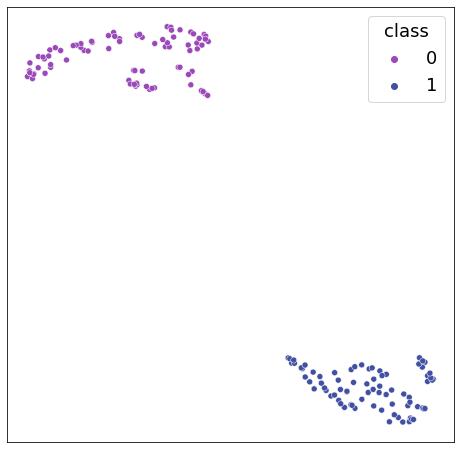

In [644]:
waves = normalize(np.vstack(df_cc_acsf_filt['waveforms']))
lables_wave,mapper,reducer = plot_UMAP_clusters_single(waves,
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 0.1,
                          c_list =coherence_colors,
                          )

<ipython-input-646-7a1c9136ee50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc_acsf_filt['LV_ID'] =lables_wave


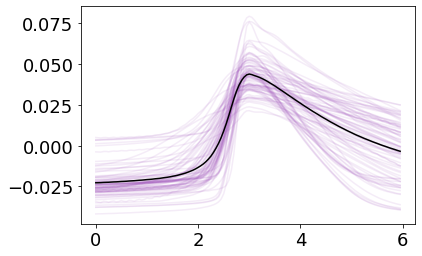

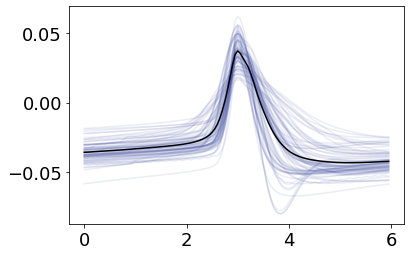

In [646]:
df_cc_acsf_filt['LV_ID'] =lables_wave 
for i in range(len(set(lables_wave))):
    fig = plt.Figure(figsize=[2,2])
    to_plot = np.vstack(df_cc_acsf_filt[df_cc_acsf_filt.LV_ID==i]['waveforms']).T
    plt.plot(np.arange(0,120/20,1/20),to_plot,c=coherence_colors[i],alpha=0.1)

    # plt.title('cluster '+str(i))
    plt.plot(np.arange(0,120/20,1/20),np.mean(np.vstack(df_cc_acsf_filt[df_cc_acsf_filt.LV_ID==i]['waveforms']).T,axis=1),c='black',alpha=1)
    plt.show()

In [647]:
exps_exc = df_cc_acsf_filt[df_cc_acsf_filt.LV_ID==0].exp_name
exps_inh = df_cc_acsf_filt[df_cc_acsf_filt.LV_ID==1].exp_name

df_exc_cc = df_cc[df_cc.exp_name.isin(exps_exc)]
df_inh_cc = df_cc[df_cc.exp_name.isin(exps_inh)]

In [648]:
all_drugs = set(df_inh_cc.cond)

In [650]:

pd.DataFrame({'Drug':np.unique(df_inh_cc.cond,return_counts=True)[0],'counts':np.unique(df_inh_cc.cond,return_counts=True)[1]})
pd.DataFrame({'Drug':np.unique(df_exc_cc.cond,return_counts=True)[0],'counts':np.unique(df_exc_cc.cond,return_counts=True)[1]})

,Drug,counts
0,5HT-1f(S1 cortex),2
1,5HT1f(M1 cortex),32
2,Alpha1,30
3,D1,49
4,D2,6
5,M1,38
6,dopamine,2


In [651]:
df_inh_cc.columns

Index(['waveforms', 'current_first_spike', 'ap_count', 'abs_firing_rate',
       'inst_firing_rate', 'time_to_first_spike', 'mean_isi', 'max_isi',
       'min_isi', 'median_isi', 'first_thrs', 'mean_thrs', 'max_thrs',
       'min_thrs', 'median_thrs', 'first_hwidths', 'mean_hwidths',
       'median_hwidths', 'max_hwidths', 'min_hwidths', 'first_amp', 'mean_amp',
       'median_amp', 'max_amp', 'min_amp', 'cond', 'drug', 'exp_name',
       'trialnr'],
      dtype='object')

In [652]:
df = plot_significance_CC(df_exc_cc,'D2','ap_count',path_try=path_temp,debug=True,save=False)
np.unique(df.drug,return_counts=True)

(array([False, True], dtype=object), array([3, 3], dtype=int64))

In [659]:
for i in set(df_exc_cc.cond):
    print(i)
    print(np.unique(df_exc_cc[df_exc_cc.cond==i].drug,return_counts=True)[1])

D2
[3 3]
5HT1f(M1 cortex)
[16 16]
Alpha1
[15 15]
dopamine
[1 1]
M1
[19 19]
D1
[27 22]
5HT-1f(S1 cortex)
[1 1]


In [746]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
# df_exc_cc = df_exc_cc.dropna() 
all_drugs_exc = set(df_exc_cc.cond)
for drug in all_drugs_exc:
    if drug !='acsf':
        # try:
            for i in ['ap_count', 'abs_firing_rate','mean_isi','mean_thrs','mean_hwidths','mean_amp']:
                path_temp = 'D:/figs_significance_all_conditions_CC/Exc/'+drug+'/'
                plot_significance_CC(df_exc_cc,drug,i,path_try=path_temp,paired=True,debug=False,save=True)
        # except:
        #     False

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. D2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.714e-01 U_stat=2.200e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. D2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.714e-01 U_stat=2.200e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. D2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.465e-01 U_stat=3.165e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. D2: Mann-Whitne

In [680]:
# import matplotlib
# matplotlib.rcParams.update({'font.size': 18})
# df_exc_cc = df_exc_cc.dropna() 
all_drugs_inh = set(df_inh_cc.cond)
for drug in all_drugs_inh:
    if drug !='acsf':
        try:
            for i in ['ap_count', 'abs_firing_rate','mean_isi','mean_thrs','mean_hwidths','mean_amp']:
                path_temp = 'D:/figs_significance_all_conditions_CC/Inh/'+drug+'/'
                plot_significance_CC(df_inh_cc,drug,i,path_try=path_temp,debug=False,save=True)
        except:
            False

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. 5HT1f(M1 cortex): t-test paired samples, P_val:2.129e-02 t=-2.510e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. 5HT1f(M1 cortex): t-test paired samples, P_val:2.129e-02 t=-2.510e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. 5HT1f(M1 cortex): t-test paired samples, P_val:6.949e-01 t=3.982e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. 5HT1f(M1 cortex): t-test paired

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. 5HT-1f(S1 cortex): t-test paired samples, P_val:nan t=nan


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. 5HT-1f(S1 cortex): t-test paired samples, P_val:nan t=nan


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. 5HT-1f(S1 cortex): t-test paired samples, P_val:nan t=nan


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. 5HT-1f(S1 cortex): t-test paired samples, P_val:nan t=nan


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. 5HT-1f(S1 cortex): t-test paired samples, P_val:nan t=nan


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

acsf vs. 5HT-1f(S1 cortex): t-test paired samples, P_val:nan t=nan


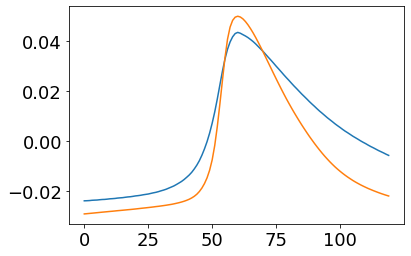

In [84]:
wave_acsf = np.mean(np.vstack(df_exc_cc[df_exc_cc.cond=='acsf']['waveforms']),axis=0)
wave_d1 = np.mean(np.vstack(df_exc_cc[df_exc_cc.cond=='D1']['waveforms']),axis=0)

plt.plot(wave_acsf.T)

plt.plot(wave_d1.T)